In [1]:
import torch
from torcheval.metrics.functional import binary_accuracy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py

## Dataset Loading, Visualize & Proprocessing

In [2]:
# Loading the data (cat/non-cat)
train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
test_dataset = h5py.File('data/test_catvnoncat.h5', "r")

train_X_orig = torch.tensor( train_dataset['train_set_x'][:].reshape(209,-1), dtype=torch.float32)  # (m, d)=(209, 12288);  from (209,64,64,3)
train_Y = torch.tensor( train_dataset['train_set_y'][:].reshape(209,-1), dtype=torch.float32)           # (m, 1)=(209, 1)

test_X_orig = torch.tensor( test_dataset['test_set_x'][:].reshape(50,-1), dtype=torch.float32)  # (50, 12288)
test_Y = torch.tensor( test_dataset['test_set_y'][:].reshape(50,-1), dtype=torch.float32)          # (50, 1)

train_X = train_X_orig/255.0
test_X = test_X_orig/255.0

In [3]:
print (f"Number of training examples: m_train = {train_X_orig.shape[1]}")
print (f"Number of testing examples: m_test = {test_X_orig.shape[1]}")
print ("Each image is of size: (64, 64, 3) \n")
print (f"train_X shape: {train_X.shape}")
print (f"train_Y shape: {train_Y.shape}")
print (f"test_X shape: {test_X.shape}")
print (f"test_Y shape: {test_Y.shape}")

Number of training examples: m_train = 12288
Number of testing examples: m_test = 12288
Each image is of size: (64, 64, 3) 

train_X shape: torch.Size([209, 12288])
train_Y shape: torch.Size([209, 1])
test_X shape: torch.Size([50, 12288])
test_Y shape: torch.Size([50, 1])


y = 1, it's a 'cat' picture.


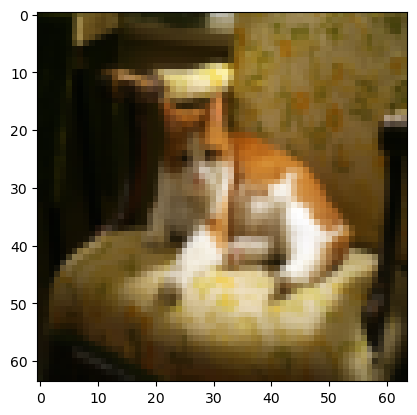

In [4]:
classes = test_dataset["list_classes"][:] # the list of classes
# Visualize sample picture
index = 7
plt.imshow(train_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print (f"y = {int(train_Y[index])}, it's a '{classes[int(train_Y[index])].decode('utf-8')}' picture.")

## Model

### Old
$ \boldsymbol{X} = \begin{bmatrix} \boldsymbol x^1 & \boldsymbol{x}^2 & \dots & \boldsymbol x^m \end{bmatrix}  $ 
$ \qquad where \qquad 
\boldsymbol x^i = \begin{bmatrix} f_1 \\ f_2 \\ f_3 \\ \vdots \\ f_d \end{bmatrix}
\qquad \qquad \qquad$ 
<br>
So &emsp; $\boldsymbol X \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,m)} $ 
&emsp; where &emsp; $\boldsymbol x^i \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,1)}$
<br>
<br>
$ \boldsymbol{Y} = \begin{bmatrix} y^1 & y^2 & \dots & y^m \end{bmatrix} 
\qquad \qquad where \qquad 
y^i$ is 0/1
<br>
So &emsp; $\boldsymbol Y \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,m)}$ 

$ \boldsymbol \omega = \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_d \end{bmatrix},\qquad b $
<br>
$ \boldsymbol \omega \rightarrow \color{purple}{\ shape: \ }\color{blue}{(d,1)}$
$,\qquad b \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,)}$ 

$ \boldsymbol{z} = \boldsymbol{\omega^T X}+b 
\qquad \qquad
\color{purple}{ \ shape: \ } \color{blue}{(1,m)=(1,d)\times(d,m)} $
<br>
$ \boldsymbol{z} = \begin{bmatrix} z^1 & z^2 & \dots & z^m \end{bmatrix}  $ 

### Now
$ \boldsymbol{X} = \begin{bmatrix} \quad \boldsymbol x^1 \quad 
\\ \quad \boldsymbol{x}^2 \quad \\ \quad \vdots \quad \\ \quad \boldsymbol x^m \quad \end{bmatrix} $ 
$ \qquad where \qquad 
\boldsymbol x^i = \begin{bmatrix} f_1 & f_2 & f_3 & \dots \quad f_d \end{bmatrix}
\qquad \qquad \qquad$ 
<br>
<br>
So &emsp; $\boldsymbol X \rightarrow \color{purple}{\ shape: \ }\color{blue}{(m,d)} $ 
&emsp; where &emsp; $\boldsymbol x^i \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,d)}$
<br>
<br>
$ \boldsymbol{Y} = \begin{bmatrix} y^1 \\ y^2 \\ \vdots \\ y^m \end{bmatrix} 
\qquad \qquad where \qquad 
y^i$ is 0/1
<br>
<br>
So &emsp; $\boldsymbol Y \rightarrow \color{purple}{\ shape: \ }\color{blue}{(m,1)}$ 

$ \boldsymbol \omega = \begin{bmatrix} w_1 & w_2 & w_3 & \dots & w_d \end{bmatrix},\qquad b $
<br>
$ \boldsymbol \omega \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,d)}$
$,\qquad \qquad \qquad b \rightarrow \color{purple}{\ shape: \ }\color{blue}{(1,)}$ 

build-in dense(X)
<br>
$ \boldsymbol{z/linear/dense} = \boldsymbol{X \omega^T}+b 
\qquad \qquad
\color{purple}{ \ shape: \ } \color{blue}{(m,1)=(m,d)\times(d,1)} $
<br>
$ \boldsymbol z = \begin{bmatrix} z^1 \\ z^2 \\ \vdots \\ z^m \end{bmatrix} $

In [5]:
class forward_class(torch.nn.Module):  
    # Constructor
    def __init__(self, input_size=2, output_size=1):
        super(forward_class, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        # weights initialized to zeros
        with torch.no_grad():
            self.linear.weight.copy_(torch.zeros(output_size,input_size))
            self.linear.bias.copy_( torch.zeros(output_size) )
    # Prediction function
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [6]:
def logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=0.005, print_cost=False):
    """
    Single neuron flavoured logistic regression model that runs for num_epochs.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32

    Returns
    -------
    d: dictionary {train_Y_pred_out, test_Y_pred_out, costs, train_acc,
         w, b, dw, db, learning_rate, num_epochs}
    train_Y_pred_out : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    w : Tensor [shape: (1, #features)]; dtype=tf.float32
    b : Tensor [shape: (1)]; dtype=tf.float32
    costs: list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    train_acc = []                                    # To keep track of the train accuracy

    ## Initialize build-in classes
    forward_node = forward_class(input_size=train_X.shape[-1], output_size=1)
    bce = torch.nn.BCELoss(reduction='mean')
    optimizer = torch.optim.SGD(forward_node.parameters(), lr = learning_rate)

    ## epochs loop
    for i in range(num_epochs): 
        ## forward pass
        train_Y_pred = forward_node(train_X)       # (12288,1)=(m,1)
        cost = bce(train_Y_pred, train_Y)
        
        ## backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ## Record the costs
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.item())
            ## Binary Accuracy
            acc = binary_accuracy(input=train_Y_pred.view(-1,), target=train_Y.view(-1,), threshold=0.5)
            train_acc.append(acc.item()*100)
            ## Print the cost every 100 training epochs
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.item()}")

    ## Predict train/test set examples
    train_Y_pred = forward_node(train_X)                          # shape(m,1); Tensor float32
    train_Y_pred_out = (train_Y_pred > 0.5).type(torch.float32)   # shape(m,1); Tensor float32
    test_Y_pred = forward_node(test_X)               
    test_Y_pred_out = (test_Y_pred > 0.5).type(torch.float32)

    ## Print train/test Errors
    if print_cost:
        acc = binary_accuracy(input=train_Y_pred.view(-1,), target=train_Y.view(-1,), threshold=0.5)
        print(f"train accuracy: { acc.item() *100 } %")
        acc = binary_accuracy(input=test_Y_pred.view(-1,), target=test_Y.view(-1,), threshold=0.5)
        print(f"test accuracy: { acc.item() *100 } %")

    d = { 
         "train_Y_pred_out" : train_Y_pred_out, "test_Y_pred_out" : test_Y_pred_out, 
         "costs": costs, "w" : forward_node.linear.weight.detach(), "b" : forward_node.linear.bias.detach(),
         "dw" : forward_node.linear.weight.grad, "db" : forward_node.linear.bias.grad,
         "learning_rate" : learning_rate, "num_epochs": num_epochs}
    
    return d

## Run Model

In [7]:
neuron_model = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=0.005, print_cost=True)

Cost in epochs 1, 0.6931471824645996
Cost in epochs 101, 0.5845084190368652
Cost in epochs 201, 0.46694910526275635
Cost in epochs 301, 0.37600693106651306
Cost in epochs 401, 0.3314632773399353
Cost in epochs 501, 0.30327308177948
Cost in epochs 601, 0.2798795700073242
Cost in epochs 701, 0.26004213094711304
Cost in epochs 801, 0.24294064939022064
Cost in epochs 901, 0.22800423204898834
Cost in epochs 1001, 0.2148195058107376
Cost in epochs 1101, 0.20307819545269012
Cost in epochs 1201, 0.19254426658153534
Cost in epochs 1301, 0.18303333222866058
Cost in epochs 1401, 0.17439860105514526
Cost in epochs 1501, 0.16652138531208038
Cost in epochs 1601, 0.15930449962615967
Cost in epochs 1701, 0.1526673287153244
Cost in epochs 1801, 0.1465422362089157
Cost in epochs 1901, 0.1408720761537552
Cost in epochs 2000, 0.1356588453054428
train accuracy: 99.04305934906006 %
test accuracy: 69.9999988079071 %


**Comment**: Training accuracy is close to 100%. This is a good sanity check: Test accuracy is 70%. The model is clearly overfitting the training data. It can be reduced by regularization technique and using more layers neural network to capture nonlinear complexity better.

## Plot results

y = 1,  but y_pred = 1 so predicted that it is a 'cat' picture.


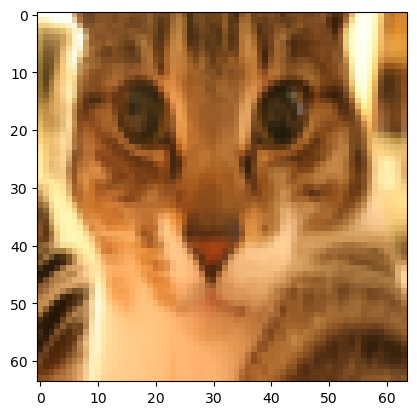

In [8]:
# Example of a picture that is rightly classified.
index = 3
plt.imshow(test_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print(f"y = {int(test_Y[index])},  but y_pred = {int(neuron_model['test_Y_pred_out'][index])} so predicted that it is a '{classes[int(neuron_model['test_Y_pred_out'][index])].decode('utf-8')}' picture.")

y = 0, but y_pred = 1 so predicted that it is a 'cat' picture.


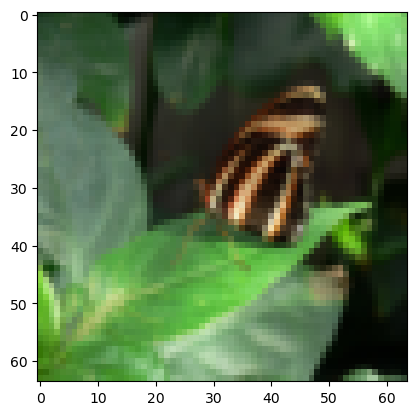

In [9]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_X_orig[index].numpy().astype(np.uint8).reshape(64,64,3))
print(f"y = {int(test_Y[index])}, but y_pred = {int(neuron_model['test_Y_pred_out'][index])} so predicted that it is a '{classes[int(neuron_model['test_Y_pred_out'][index])].decode('utf-8')}' picture.")

Let's also plot the cost function and the gradients.

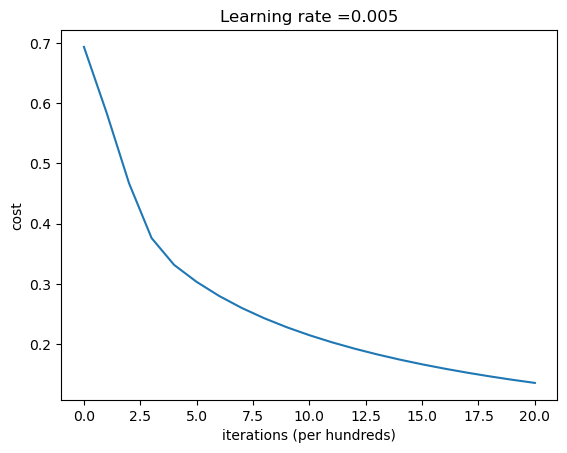

In [10]:
# Plot learning curve (with costs)
costs = np.squeeze(neuron_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(neuron_model["learning_rate"]))
plt.show()

**Interpretation**:
The cost decreasing shows that the parameters are being learned. However, could train the model even more on the training set. Increasing the number of iterations/epochs result in the training accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work, must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly change the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of `learning rates`. Run the cell below. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



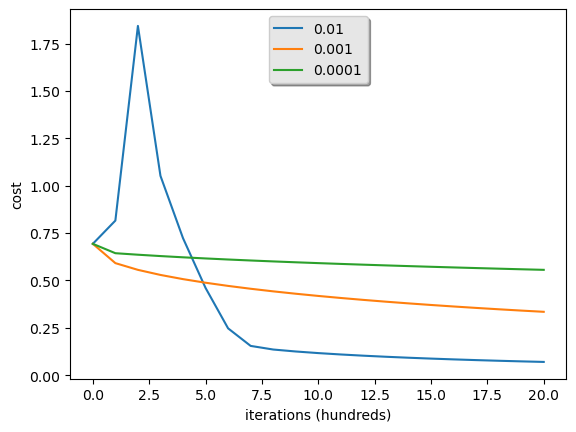

In [11]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If model overfits, use other techniques to reduce overfitting.


## Test with your own image ##

Use your own image and see the output of your model. To do that:<br>
1. Add image to this Jupyter Notebook's directory, in the "img" folder.<br>
2. Change your image's name in the following code<br>
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!<br>

y_pred = 0, neuron algorithm predicts a 'non-cat' picture.


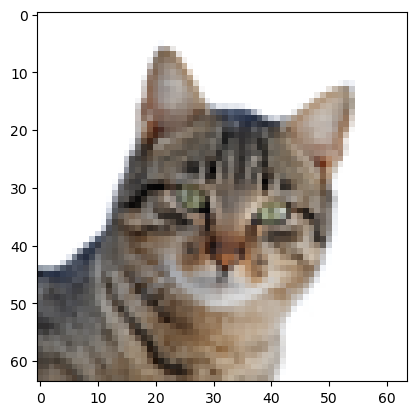

In [12]:
# change this to the name of your image file
my_image = "img/my_image_1.jpg"   

num_px = 64
# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3))   # np.ndarray shape(1, 12288); float64
image = torch.tensor(image, dtype=torch.float32)   # shape(1, 12288); float32

w=neuron_model["w"]; b=neuron_model["b"]
z = torch.mm(image, w.T) + b    # shape(1,1) --> (1,d)X(d,1); EagerTensor float32
Y_pred = torch.sigmoid(z)                              
my_image_pred = (Y_pred > 0.5).type(torch.float32)    

print(f"y_pred = {int(my_image_pred)}, neuron algorithm predicts a '{classes[int(my_image_pred)].decode('utf-8')}' picture.")

y_pred = 1, neuron algorithm predicts a 'cat' picture.


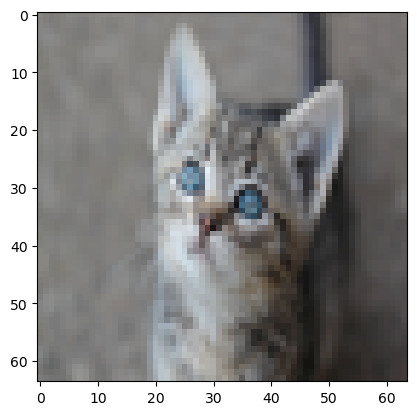

In [13]:
# change this to the name of your image file
my_image = "img/my_image_2.jpg"   

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3))    # np.ndarray shape(1, 12288)
image = torch.tensor(image, dtype=torch.float32)   # shape(1, 12288); float32

w=neuron_model["w"]; b=neuron_model["b"]
z = torch.mm(image, w.T) + b    # shape(1,1) --> (1,d)X(d,1); EagerTensor float32
Y_pred = torch.sigmoid(z)                              
my_image_pred = (Y_pred > 0.5).type(torch.float32)  

print(f"y_pred = {int(my_image_pred)}, neuron algorithm predicts a '{classes[int(my_image_pred)].decode('utf-8')}' picture.")